# **FYP-EEE-A3245-211**
# **Face Transformation using StyleGAN**

This is a Google Colab notebook for learning controls for StyleGAN image synthesis.


---
# **0. Install/Import Prerequisites**

In [1]:
!pip install --upgrade --no-cache-dir gdown

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-4.4.0-py3-none-any.whl size=14774 sha256=dbcf440f0a0bcdcf1c09ac275aaba2c417e9a5481cd21ce73872b80b057044a3
  Stored in directory: /tmp/pip-ephem-wheel-cache-i9jvb343/wheels/fb/c3/0e/c4d8ff8bfcb0461afff199471449f642179b74968c15b7a69c
Successfully built gdown
  Attempting uninstall: gdown
    Found existing installation: gdown 4.2.2
    Uninstalling gdown-4.2.2:
      Successfully uninstalled gdown-4.2.2


In [2]:
!pip install ninja

     |████████████████████████████████| 108 kB 12.8 MB/s 


In [3]:
# clone StyleGAN2 repo
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch

Cloning into 'stylegan2-ada-pytorch'...
remote: Enumerating objects: 128, done.
remote: Total 128 (delta 0), reused 0 (delta 0), pack-reused 128
Receiving objects: 100% (128/128), 1.12 MiB | 1.24 MiB/s, done.
Resolving deltas: 100% (57/57), done.


In [4]:
# download pretrained network (stylegan2-ffhq-config-f)
!gdown --id 1f9ZWi2iV26AMixY1dtO_tkc59oSCvDTS

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1f9ZWi2iV26AMixY1dtO_tkc59oSCvDTS
To: /content/stylegan2-ffhq-config-f.pkl
100% 382M/382M [00:03<00:00, 126MB/s]


In [5]:
# download groundtruth
!gdown --id 1V_WFNOBpGOx_mgi3Ajmrd_41EeZWpcxE

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1V_WFNOBpGOx_mgi3Ajmrd_41EeZWpcxE
To: /content/groundtruth.csv
100% 43.0k/43.0k [00:00<00:00, 35.4MB/s]


In [106]:
# download an already projected face numpy latent vector file (*.npz)

# projected image : Leonardo DiCaprio 2017
# https://commons.wikimedia.org/wiki/File:Leonardo_DiCaprio_2017.jpg
# Reunión con Leonardo DiCaprio y Carlos Slim by Presidencia de la República Mexicana CC BY 2.0

!gdown --id 1TdjuzqeVBJzyrrOQpZzeirewxVKL6oQy

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1TdjuzqeVBJzyrrOQpZzeirewxVKL6oQy
To: /content/LeonardoDicaprio.npz
100% 37.1k/37.1k [00:00<00:00, 46.4MB/s]


# **1. Loading the Labelled Dataset**

In [6]:
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

**Groundtruths**
<table>
<tr>
    <th>Target Attributes</th>
    <th>Classes</th>
</tr>
<tr>
    <td>gender</td>
    <td>{'female' : 0, 'male' : 1, 'unidentified : 2'}</td>
</tr>
<tr>
    <td>glasses</td>
    <td>{'no glasses' : 0, 'glasses' : 1}</td>
</tr>
<tr>
    <td>hat</td>
    <td>{'no hat' : 0, 'hat' : 1}</td>
</tr>
<tr>
    <td>head_pose</td>
    <td>{'front' : 0, 'right' : 1, 'left' : 2}</td>
</tr>
<tr>
    <td>hair length</td>
    <td>{'short' : 0, 'medium' : 1, 'long' : 2}</td>
</tr>
<tr>
    <td>earring</td>
    <td>{'no earring' : 0, 'small earring' : 1, 'large earring' : 2}</td>
</tr>
<tr>
    <td>facial hair</td>
    <td>{'no facial hair' : 0, 'little facial hair' : 1, 'more facial hair' : 2}</td>
</tr>
<tr>
    <td>smile</td>
    <td>{'no smile' : 0, 'close smile' : 1, 'half smile' : 2, 'full smile' : 3}</td>
</tr>
</table>

In [7]:
df = pd.read_csv('/content/groundtruth.csv')

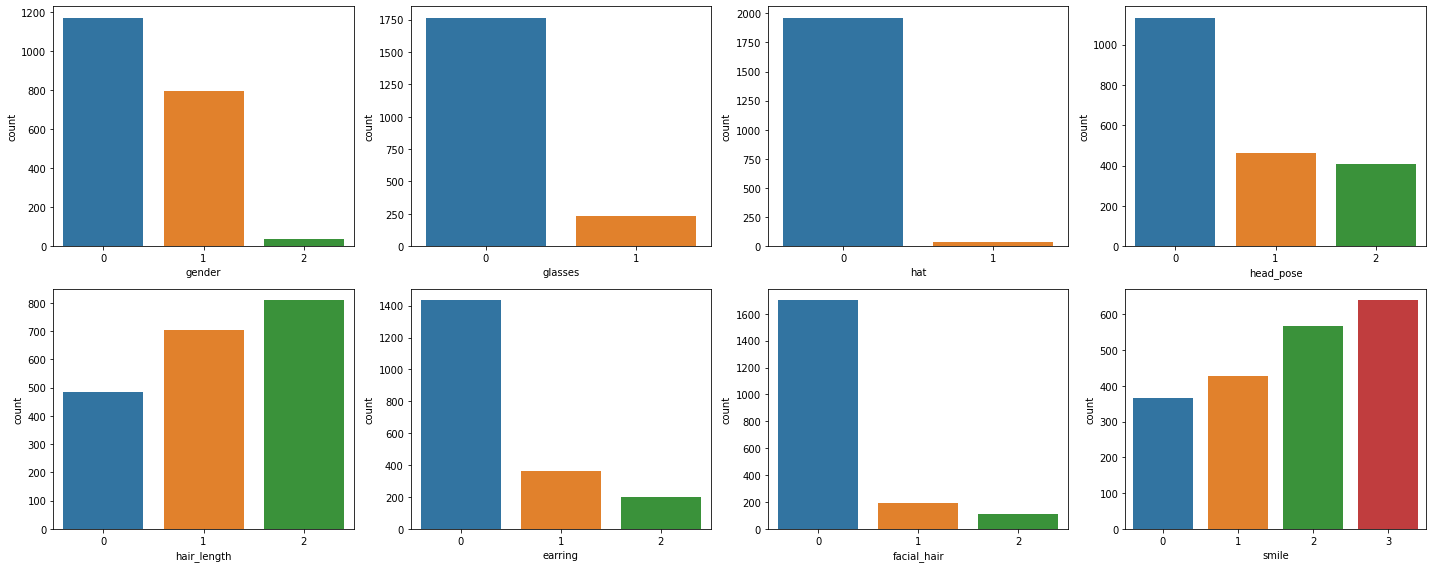

In [8]:
# visualize dataset distribution
_, axes = plt.subplots(2, 4, figsize=(20,8))
sns.countplot(data=df, x='gender', ax=axes[0,0]);
sns.countplot(data=df, x='glasses', ax=axes[0,1]);
sns.countplot(data=df, x='hat', ax=axes[0,2]);
sns.countplot(data=df, x='head_pose', ax=axes[0,3]);
sns.countplot(data=df, x='hair_length', ax=axes[1,0]);
sns.countplot(data=df, x='earring', ax=axes[1,1]);
sns.countplot(data=df, x='facial_hair', ax=axes[1,2]);
sns.countplot(data=df, x='smile', ax=axes[1,3]);
plt.tight_layout()
plt.show()

# **2. Setting up StyleGAN2**

In [9]:
%cd /content/stylegan2-ada-pytorch

/content/stylegan2-ada-pytorch


In [10]:
import torch
import random
import warnings

import numpy as np

import dnnlib
import legacy

## **2.1. Helper Functions**

In [11]:
from IPython.display import Markdown, display

# enable print message with html style
def printmd(string):
    display(Markdown(string))

In [12]:
# Generate latent vector
def generate_latent_vector(seed, shape):
  # Construct random number generator
  # Generate vector of size[1,512]
  rnd = np.random.RandomState(seed)
  z = rnd.randn(1, shape)
  return z

# Generate Image
def generate_image(z, label, truncation_psi=0.5, noise_mode="const"):
  z = torch.from_numpy(z).to(device)
  img_gpu = G(z, label, truncation_psi=truncation_psi, noise_mode=noise_mode)
  img_tensor = (img_gpu.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
  img = np.transpose(img_tensor.cpu().numpy()[0], (0,1,2))
  return img

## **2.2. Initialize StyleGAN2**

In [13]:
# Get shape of latent vector and torch label
def setup_image_generation(G, device):
  z_shape = G.z_dim
  zero_label = torch.zeros([1, G.c_dim], device=device)
  # print('Setting up image generation...', end=' ')
  z = generate_latent_vector(0, z_shape)
  img = generate_image(z, zero_label)
  del z, img
  # print('Done')
  return z_shape, zero_label

# Check if cuda is available
def torch_is_cuda_available():
  if torch.cuda.is_available(): 
    print('CUDA is available. Using device \'0\': %s'%(torch.cuda.get_device_name(0)))
    return 'cuda'
  else:
    warnings.warn('Warning! Using CPU...')
    return 'cpu'

def load_network(path_to_network):
  print('Unpacking network file...', end=' ')
  with dnnlib.util.open_url(path_to_network) as f:
      G = legacy.load_network_pkl(f)['G_ema'].to(device)
  print('Done')
  return G

In [14]:
path_to_network = '/content/stylegan2-ffhq-config-f.pkl'

In [15]:
# Initialize network and setup for image generation
device = torch.device(torch_is_cuda_available())
G = load_network(path_to_network)
(z_shape, label) = setup_image_generation(G, device)
print('Ready')

CUDA is available. Using device '0': Tesla K80
Unpacking network file... Done
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
Ready


# **3. Preparing Data for Training**

In [16]:
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import SGDRegressor

## **3.1. Gender**

In [17]:
def get_gender_data():
  # locate gender classes in dataset
  gender_female = df.loc[(df['gender']==0)]['gender']
  gender_male = df.loc[(df['gender']==1)]['gender']

  # get the seeds for each gender class
  gender_female_seeds = list(gender_female.index.values)
  gender_male_seeds = list(gender_male.index.values)

  # downsample each class to the minimum class count
  gender_min = min(len(gender_male_seeds), len(gender_female_seeds))
  gender_female_seeds = random.sample(gender_female_seeds, gender_min)
  gender_male_seeds = random.sample(gender_male_seeds, gender_min)

  # generate latent vector for training
  gender_seeds = np.concatenate([gender_female_seeds, gender_male_seeds], axis=0)
  X_gender = np.array([generate_latent_vector(seed, z_shape)[0] for seed in gender_seeds])

  # generate labels for training
  Y_gender = np.zeros(gender_min*2, dtype='int')
  Y_gender[gender_min:] = 1
  u, c = np.unique(Y_gender, return_counts=True)

  printmd('<u><b>X_gender</b></u>')
  print('Shape : %s\n'%(str(X_gender.shape)))

  printmd('<u><b>Y_gender</b></u>')
  print('Unique : %s'%(u))
  print('Shape  : %s'%(c))
  return X_gender, Y_gender

## **3.2. Glasses**

In [18]:
def get_glasses_data():
  # locate glasses classes in dataset
  glasses = df.loc[(df['glasses']==1)]['glasses']
  no_glasses = df.loc[(df['glasses']==0)]['glasses']

  # get the seeds for each glasses class
  glasses_seeds = list(glasses.index.values)
  no_glasses_seeds = list(no_glasses.index.values)

  # downsample each class to the minimum class count
  glasses_min = min(len(glasses_seeds), len(no_glasses_seeds))
  glasses_seeds = random.sample(glasses_seeds, glasses_min)
  no_glasses_seeds = random.sample(no_glasses_seeds, glasses_min)

  # generate latent vector for training
  glasses_seeds = np.concatenate([glasses_seeds, no_glasses_seeds], axis=0)
  X_glasses = np.array([generate_latent_vector(seed, z_shape)[0] for seed in glasses_seeds])

  # generate labels for training
  Y_glasses = np.zeros(glasses_min*2, dtype='int')
  Y_glasses[glasses_min:] = 1
  u, c = np.unique(Y_glasses, return_counts=True)

  printmd('<u><b>X_glasses</b></u>')
  print('Shape : %s\n'%(str(X_glasses.shape)))

  printmd('<u><b>Y_glasses</b></u>')
  print('Unique : %s'%(u))
  print('Shape  : %s'%(c))
  return X_glasses, Y_glasses

## **3.3. Hat**

In [20]:
def get_hat_data():
  # locate hat classes in dataset
  no_hat = df.loc[(df['hat']==0)]['hat']
  hat = df.loc[(df['hat']==1)]['hat']

  # get the seeds for each hat class
  no_hat_seeds = list(no_hat.index.values)
  hat_seeds = list(hat.index.values)

  # downsample each class to the minimum class count
  hat_min = min([len(no_hat_seeds), len(hat_seeds)])
  no_hat_seeds = random.sample(no_hat_seeds, hat_min)
  hat_seeds = random.sample(hat_seeds, hat_min)

  # generate latent vector for training
  hat_seeds = np.concatenate([no_hat_seeds, hat_seeds], axis=0)
  X_hat = np.array([generate_latent_vector(seed, z_shape)[0] for seed in hat_seeds])

  # generate labels for training
  Y_hat = np.zeros(hat_min*2, dtype='int')
  Y_hat[hat_min:] = 1
  u, c = np.unique(Y_hat, return_counts=True)

  printmd('<u><b>X_hat</b></u>')
  print('Shape : %s\n'%(str(X_hat.shape)))

  printmd('<u><b>Y_hat</b></u>')
  print('Unique : %s'%(u))
  print('Shape  : %s'%(c))
  return X_hat, Y_hat

## **3.4. Head Pose**

In [21]:
def get_head_pose_data():
  # locate head pose classes in dataset
  head_pose_center = df.loc[(df['head_pose']==0)]['head_pose']
  head_pose_right = df.loc[(df['head_pose']==1)]['head_pose']
  head_pose_left = df.loc[(df['head_pose']==2)]['head_pose']

  # get the seeds for each head pose class
  head_pose_center_seeds = list(head_pose_center.index.values)
  head_pose_right_seeds = list(head_pose_right.index.values)
  head_pose_left_seeds = list(head_pose_left.index.values)

  # downsample each class to the minimum class count
  head_pose_min = min([len(head_pose_center_seeds), 
                  len(head_pose_right_seeds),
                  len(head_pose_left_seeds)])

  head_pose_center_seeds = random.sample(head_pose_center_seeds, head_pose_min)
  head_pose_right_seeds = random.sample(head_pose_right_seeds, head_pose_min)
  head_pose_left_seeds = random.sample(head_pose_left_seeds, head_pose_min)

  # generate latent vector for training
  head_pose_seeds = np.concatenate([head_pose_center_seeds, 
                                    head_pose_right_seeds,
                                    head_pose_left_seeds], axis=0)

  X_head_pose = np.array([generate_latent_vector(seed, z_shape)[0] for seed in head_pose_seeds])

  # generate labels for training
  Y_head_pose = np.zeros(head_pose_min*3, dtype='int')
  Y_head_pose[head_pose_min:] = 1
  Y_head_pose[head_pose_min*2:] = 2
  u, c = np.unique(Y_head_pose, return_counts=True)

  printmd('<u><b>X_head_pose</b></u>')
  print('Shape : %s\n'%(str(X_head_pose.shape)))

  printmd('<u><b>Y_head_pose</b></u>')
  print('Unique : %s'%(u))
  print('Shape  : %s'%(c))
  return X_head_pose, Y_head_pose

## **3.5. Hair Length**

In [22]:
def get_hair_length_data():
  # locate hair length classes in dataset
  # separate by male and female classes
  male_short_hair_length = df.loc[(df['hair_length']==0) & (df['gender']==1)]['hair_length']
  male_medium_hair_length = df.loc[(df['hair_length']==1) & (df['gender']==1)]['hair_length']
  male_long_hair_length = df.loc[(df['hair_length']==2) & (df['gender']==1)]['hair_length']

  female_short_hair_length = df.loc[(df['hair_length']==0) & (df['gender']==0)]['hair_length']
  female_medium_hair_length = df.loc[(df['hair_length']==1) & (df['gender']==0)]['hair_length']
  female_long_hair_length = df.loc[(df['hair_length']==2) & (df['gender']==0)]['hair_length']

  # get the seeds for each hair length class
  male_short_hair_length_seeds = list(male_short_hair_length.index.values)
  male_medium_hair_length_seeds = list(male_medium_hair_length.index.values)
  male_long_hair_length_seeds = list(male_long_hair_length.index.values)

  female_short_hair_length_seeds = list(female_short_hair_length.index.values)
  female_medium_hair_length_seeds = list(female_medium_hair_length.index.values)
  female_long_hair_length_seeds = list(female_long_hair_length.index.values)

  # downsample each class to the minimum class count
  male_min = min([len(male_short_hair_length_seeds), 
                  len(male_medium_hair_length_seeds),
                  len(male_long_hair_length_seeds)])

  female_min = min([len(female_short_hair_length_seeds), 
                  len(female_medium_hair_length_seeds),
                  len(female_long_hair_length_seeds)])

  male_short_hair_length_seeds = random.sample(male_short_hair_length_seeds, male_min)
  male_medium_hair_length_seeds = random.sample(male_medium_hair_length_seeds, male_min)
  male_long_hair_length_seeds = random.sample(male_long_hair_length_seeds, male_min)

  female_short_hair_length_seeds = random.sample(female_short_hair_length_seeds, female_min)
  female_medium_hair_length_seeds = random.sample(female_medium_hair_length_seeds, female_min)
  female_long_hair_length_seeds = random.sample(female_long_hair_length_seeds, female_min)

  # generate latent vector for training
  male_seeds = np.concatenate([male_short_hair_length_seeds, 
                                male_medium_hair_length_seeds,
                                male_long_hair_length_seeds], axis=0)

  female_seeds = np.concatenate([female_short_hair_length_seeds,
                                  female_medium_hair_length_seeds,
                                  female_long_hair_length_seeds], axis=0)

  X_male = np.array([generate_latent_vector(seed, z_shape)[0] for seed in male_seeds])
  X_female = np.array([generate_latent_vector(seed, z_shape)[0] for seed in female_seeds])

  # generate labels for training
  Y_male = np.zeros(male_min*3, dtype='int')
  Y_male[male_min:] = 1
  Y_male[male_min*2:] = 2
  u, c = np.unique(Y_male, return_counts=True)

  printmd('<u><b>X_male</b></u>')
  print('Shape : %s\n'%(str(X_male.shape)))

  printmd('<u><b>Y_male</b></u>')
  print('Unique : %s'%(u))
  print('Shape  : %s\n'%(c))

  Y_female = np.zeros(female_min*3, dtype='int')
  Y_female[female_min:] = 1
  Y_female[female_min*2:] = 2
  u, c = np.unique(Y_female, return_counts=True)

  printmd('<u><b>X_female</b></u>')
  print('Shape : %s\n'%(str(X_female.shape)))

  printmd('<u><b>Y_female</b></u>')
  print('Unique : %s'%(u))
  print('Shape  : %s'%(c))
  return X_male, X_female, Y_male, Y_female

## **3.6. Earring**

In [23]:
def get_earring_data():
  # locate earring classes in dataset
  no_earring = df.loc[(df['earring']==0) & (df['gender']==0)]['earring']
  small_earring = df.loc[(df['earring']==1) & (df['gender']==0)]['earring']
  large_earring = df.loc[(df['earring']==2) & (df['gender']==0)]['earring']

  # get the seeds for each earring class
  no_earring_seeds = list(no_earring.index.values)
  small_earring_seeds = list(small_earring.index.values)
  large_earring_seeds = list(large_earring.index.values)

  # downsample each class to the minimum class count
  earring_min = min([len(no_earring_seeds), 
                      len(small_earring_seeds),
                      len(large_earring_seeds)])

  no_earring_seeds = random.sample(no_earring_seeds, earring_min)
  small_earring_seeds = random.sample(small_earring_seeds, earring_min)
  large_earring_seeds = random.sample(large_earring_seeds, earring_min)

  # generate latent vector for training
  earring_seeds = np.concatenate([no_earring_seeds, 
                                  small_earring_seeds,
                                  large_earring_seeds], axis=0)

  X_earring = np.array([generate_latent_vector(seed, z_shape)[0] for seed in earring_seeds])

  # generate labels for training
  Y_earring = np.zeros(earring_min*3, dtype='int')
  Y_earring[earring_min:] = 1
  Y_earring[earring_min*2:] = 2
  u, c = np.unique(Y_earring, return_counts=True)

  printmd('<u><b>X_earring</b></u>')
  print('Shape : %s\n'%(str(X_earring.shape)))

  printmd('<u><b>Y_earring</b></u>')
  print('Unique : %s'%(u))
  print('Shape  : %s\n'%(c))
  return X_earring, Y_earring

## **3.7. Facial Hair**

In [24]:
def get_facial_hair_data():
  # locate facial hair classes in dataset
  facial_hair_none = df.loc[(df['facial_hair']==0)]['facial_hair']
  facial_hair_little = df.loc[(df['facial_hair']==1)]['facial_hair']
  facial_hair_more = df.loc[(df['facial_hair']==2)]['facial_hair']

  # get the seeds for each facial hair class
  facial_hair_none_seeds = list(facial_hair_none.index.values)
  facial_hair_little_seeds = list(facial_hair_little.index.values)
  facial_hair_more_seeds = list(facial_hair_more.index.values)

  # downsample each class to the minimum class count
  facial_hair_min = min([len(facial_hair_none), 
                  len(facial_hair_little),
                  len(facial_hair_more)])

  facial_hair_none_seeds = random.sample(facial_hair_none_seeds, facial_hair_min)
  facial_hair_little_seeds = random.sample(facial_hair_little_seeds, facial_hair_min)
  facial_hair_more_seeds = random.sample(facial_hair_more_seeds, facial_hair_min)

  # generate latent vector for training
  facial_hair_seeds = np.concatenate([facial_hair_none_seeds, 
                                    facial_hair_little_seeds,
                                    facial_hair_more_seeds], axis=0)

  X_facial_hair = np.array([generate_latent_vector(seed, z_shape)[0] for seed in facial_hair_seeds])

  # generate labels for training
  Y_facial_hair = np.zeros(facial_hair_min*3, dtype='int')
  Y_facial_hair[facial_hair_min:] = 1
  Y_facial_hair[facial_hair_min*2:] = 2
  u, c = np.unique(Y_facial_hair, return_counts=True)

  printmd('<u><b>X_facial_hair</b></u>')
  print('Shape : %s\n'%(str(X_facial_hair.shape)))

  printmd('<u><b>Y_facial_hair</b></u>')
  print('Unique : %s'%(u))
  print('Shape  : %s\n'%(c))
  return X_facial_hair, Y_facial_hair

## **3.8. Smile**

In [25]:
def get_smile_data():
  # locate smile classes in dataset
  smile_no = df.loc[(df['smile']==0)]['smile']
  smile_close = df.loc[(df['smile']==1)]['smile']
  smile_half = df.loc[(df['smile']==2)]['smile']
  smile_full = df.loc[(df['smile']==3)]['smile']

  # get the seeds for each smile class
  smile_no_seeds = list(smile_no.index.values)
  smile_close_seeds = list(smile_close.index.values)
  smile_half_seeds = list(smile_half.index.values)
  smile_full_seeds = list(smile_full.index.values)

  # downsample each class to the minimum class count
  smile_min = min([len(smile_no_seeds), 
                      len(smile_close_seeds),
                      len(smile_half_seeds),
                      len(smile_full_seeds)])

  smile_no_seeds = random.sample(smile_no_seeds, smile_min)
  smile_close_seeds = random.sample(smile_close_seeds, smile_min)
  smile_half_seeds = random.sample(smile_half_seeds, smile_min) 
  smile_full_seeds = random.sample(smile_full_seeds, smile_min)

  # generate latent vector for training
  smile_seeds = np.concatenate([smile_no_seeds, 
                                smile_close_seeds,
                                smile_half_seeds,
                                smile_full_seeds], axis=0)

  X_smile = np.array([generate_latent_vector(seed, z_shape)[0] for seed in smile_seeds])

  # generate labels for training
  Y_smile = np.zeros(smile_min*4, dtype='int')
  Y_smile[smile_min:] = 1
  Y_smile[smile_min*2:] = 2
  Y_smile[smile_min*3:] = 3
  u, c = np.unique(Y_smile, return_counts=True)

  printmd('<u><b>X_smile</b></u>')
  print('Shape : %s\n'%(str(X_smile.shape)))

  printmd('<u><b>Y_smile</b></u>')
  print('Unique : %s'%(u))
  print('Shape  : %s\n'%(c))
  return X_smile, Y_smile

# **4. Model Training**

In [26]:
# create folders to hold learned coefficients
!mkdir /content/coefficients
!mkdir /content/coefficients/SVC
!mkdir /content/coefficients/SVR

In [27]:
# Generic Linear SVC & SVR Training Functions

def linear_support_vector_classifier(X_data, Y_labels):
  printmd('**<u>SVM Classifier Scores</u>**')

  SVC = SGDClassifier(class_weight='balanced', loss='hinge', random_state=0)
  SVC_scores = cross_val_score(SVC, X_data, Y_labels, scoring='accuracy', cv=5)
  SVC.fit(X_data, Y_labels)
  return SVC, SVC_scores

def linear_support_vector_regressor(X_data, Y_labels):
  printmd('**<u>SVM Regression Scores</u>**')

  SVR = SGDRegressor(loss='epsilon_insensitive')
  SVR_scores = cross_val_score(SVR, X_data, Y_labels, scoring='neg_root_mean_squared_error', cv=5)
  SVR.fit(X_data, Y_labels)
  return SVR, SVR_scores

## **4.1. Gender**

In [28]:
X_gender, Y_gender = get_gender_data()

<u><b>X_gender</b></u>

Shape : (1588, 512)



<u><b>Y_gender</b></u>

Unique : [0 1]
Shape  : [794 794]


In [29]:
# SVC & SVR Model Training

# Linear Support Vector Classifier
SVC_gender, SVC_gender_scores = linear_support_vector_classifier(X_gender, Y_gender)

printmd('**- Gender Scores**')
print('Cross Validation Scores: ', SVC_gender_scores)
print('Cross Validation Mean: ', np.mean(SVC_gender_scores))

# Linear Support Vector Regressor
SVR_gender, SVR_gender_scores = linear_support_vector_regressor(X_gender, Y_gender)

printmd('**- Gender Scores**')
print('Cross Validation Scores: ', abs(SVR_gender_scores))
print('Cross Validation Mean: ', np.mean(abs(SVR_gender_scores)))

**<u>SVM Classifier Scores</u>**

**- Gender Scores**

Cross Validation Scores:  [0.76415094 0.73584906 0.6918239  0.72870662 0.69400631]
Cross Validation Mean:  0.7229073666250024


**<u>SVM Regression Scores</u>**

**- Gender Scores**

Cross Validation Scores:  [0.51129685 0.58281664 0.50703558 0.57709061 0.51255177]
Cross Validation Mean:  0.538158291276486


In [30]:
# Extract and Normalize SVC & SVR Coefficient

SVC_gender_coefs = SVC_gender.coef_
SVC_gender_coefs = preprocessing.normalize(SVC_gender_coefs)
print('Normalized SVC Gender Shape: ' + str(SVC_gender_coefs.shape))

SVR_gender_coefs = SVR_gender.coef_
SVR_gender_coefs = preprocessing.normalize([SVR_gender_coefs])
print('Normalized SVR Gender Shape: ' + str(SVR_gender_coefs.shape))

Normalized SVC Gender Shape: (1, 512)
Normalized SVR Gender Shape: (1, 512)


In [31]:
np.save('/content/coefficients/SVC/SVC_gender.npy', SVC_gender_coefs)
np.save('/content/coefficients/SVR/SVR_gender.npy', SVR_gender_coefs)

## **4.2. Glasses**

In [32]:
X_glasses, Y_glasses = get_glasses_data()

<u><b>X_glasses</b></u>

Shape : (474, 512)



<u><b>Y_glasses</b></u>

Unique : [0 1]
Shape  : [237 237]


In [33]:
# SVC & SVR Model Training

# Linear Support Vector Classifier
SVC_glasses, SVC_glasses_scores = linear_support_vector_classifier(X_glasses, Y_glasses)

printmd('**- Glasses Scores**')
print('Cross Validation Scores: ', SVC_glasses_scores)
print('Cross Validation Mean: ', np.mean(SVC_glasses_scores))

# Linear Support Vector Regressor
SVR_glasses, SVR_glasses_scores = linear_support_vector_regressor(X_glasses, Y_glasses)

printmd('**- Glasses Scores**')
print('Cross Validation Scores: ', abs(SVR_glasses_scores))
print('Cross Validation Mean: ', np.mean(abs(SVR_glasses_scores)))

**<u>SVM Classifier Scores</u>**

**- Glasses Scores**

Cross Validation Scores:  [0.73684211 0.68421053 0.65263158 0.64210526 0.69148936]
Cross Validation Mean:  0.6814557670772675


**<u>SVM Regression Scores</u>**

**- Glasses Scores**

Cross Validation Scores:  [0.74604068 0.68080876 0.70051292 0.93166958 0.84545992]
Cross Validation Mean:  0.7808983694461713


In [34]:
# Extract and Normalize SVC & SVR Coefficient

SVC_glasses_coefs = SVC_glasses.coef_
SVC_glasses_coefs = preprocessing.normalize(SVC_glasses_coefs)
print('Normalized SVC Glasses Shape: ' + str(SVC_glasses_coefs.shape))

SVR_glasses_coefs = SVR_glasses.coef_
SVR_glasses_coefs = preprocessing.normalize([SVR_glasses_coefs])
print('Normalized SVR Glasses Shape: ' + str(SVR_glasses_coefs.shape))

Normalized SVC Glasses Shape: (1, 512)
Normalized SVR Glasses Shape: (1, 512)


In [35]:
np.save('/content/coefficients/SVC/SVC_glasses.npy', SVC_glasses_coefs)
np.save('/content/coefficients/SVR/SVR_glasses.npy', SVR_glasses_coefs)

## **4.3. Hat**

In [36]:
X_hat, Y_hat = get_hat_data()

<u><b>X_hat</b></u>

Shape : (78, 512)



<u><b>Y_hat</b></u>

Unique : [0 1]
Shape  : [39 39]


In [37]:
# SVC & SVR Model Training

# Linear Support Vector Classifier
SVC_hat, SVC_hat_scores = linear_support_vector_classifier(X_hat, Y_hat)

printmd('**- Hat Scores**')
print('Cross Validation Scores: ', SVC_hat_scores)
print('Cross Validation Mean: ', np.mean(SVC_hat_scores))

# Linear Support Vector Regressor
SVR_hat, SVR_hat_scores = linear_support_vector_regressor(X_hat, Y_hat)

printmd('**- Hat Scores**')
print('Cross Validation Scores: ', abs(SVR_hat_scores))
print('Cross Validation Mean: ', np.mean(abs(SVR_hat_scores)))

**<u>SVM Classifier Scores</u>**

**- Hat Scores**

Cross Validation Scores:  [0.5625     0.75       0.8125     0.6        0.66666667]
Cross Validation Mean:  0.6783333333333333


**<u>SVM Regression Scores</u>**

**- Hat Scores**

Cross Validation Scores:  [0.26065684 0.33721828 0.68530268 0.90005635 0.94867909]
Cross Validation Mean:  0.6263826468254112


In [38]:
# Extract and Normalize SVC & SVR Coefficient

SVC_hat_coefs = SVC_hat.coef_
SVC_hat_coefs = preprocessing.normalize(SVC_hat_coefs)
print('Normalized SVC Hat Shape: ' + str(SVC_hat_coefs.shape))

SVR_hat_coefs = SVR_hat.coef_
SVR_hat_coefs = preprocessing.normalize([SVR_hat_coefs])
print('Normalized SVR Hat Shape: ' + str(SVR_hat_coefs.shape))

Normalized SVC Hat Shape: (1, 512)
Normalized SVR Hat Shape: (1, 512)


In [39]:
np.save('/content/coefficients/SVC/SVC_hat.npy', SVC_hat_coefs)
np.save('/content/coefficients/SVR/SVR_hat.npy', SVR_hat_coefs)

## **4.4. Head Pose**

In [40]:
X_head_pose, Y_head_pose = get_head_pose_data()

<u><b>X_head_pose</b></u>

Shape : (1218, 512)



<u><b>Y_head_pose</b></u>

Unique : [0 1 2]
Shape  : [406 406 406]


In [41]:
# SVC & SVR Model Training

# Linear Support Vector Classifier
SVC_head_pose, SVC_head_pose_scores = linear_support_vector_classifier(X_head_pose, Y_head_pose)

printmd('**- Head Pose Scores**')
print('Cross Validation Scores: ', SVC_head_pose_scores)
print('Cross Validation Mean: ', np.mean(SVC_head_pose_scores))

# Linear Support Vector Regressor
SVR_head_pose, SVR_head_pose_scores = linear_support_vector_regressor(X_head_pose, Y_head_pose)

printmd('**- Head Pose Scores**')
print('Cross Validation Scores: ', abs(SVR_head_pose_scores))
print('Cross Validation Mean: ', np.mean(abs(SVR_head_pose_scores)))

**<u>SVM Classifier Scores</u>**

**- Head Pose Scores**

Cross Validation Scores:  [0.52459016 0.59016393 0.49590164 0.50205761 0.52674897]
Cross Validation Mean:  0.5278924644134116


**<u>SVM Regression Scores</u>**

**- Head Pose Scores**

Cross Validation Scores:  [1.43349494 1.32732204 1.11842521 1.26696777 1.37232564]
Cross Validation Mean:  1.3037071209901936


In [42]:
# Extract and Normalize SVC & SVR Coefficient

SVC_head_pose_coefs = SVC_head_pose.coef_
SVC_head_pose_coefs = preprocessing.normalize(SVC_head_pose_coefs)
print('Normalized SVC Head Pose Shape: ' + str(SVC_head_pose_coefs.shape))

SVR_head_pose_coefs = SVR_head_pose.coef_
SVR_head_pose_coefs = preprocessing.normalize([SVR_head_pose_coefs])
print('Normalized SVR Head Pose Shape: ' + str(SVR_head_pose_coefs.shape))

Normalized SVC Head Pose Shape: (3, 512)
Normalized SVR Head Pose Shape: (1, 512)


In [43]:
# Combine SVC Coefficient and reshape to (1, 512)
SVC_head_pose_coefs_0 = np.expand_dims(SVC_head_pose_coefs[0], axis=0)
SVC_head_pose_coefs_1_2 = np.expand_dims((SVC_head_pose_coefs[1] + (-SVC_head_pose_coefs[2]) / 2), axis=0)

In [44]:
np.save('/content/coefficients/SVC/SVC_head_pose_0.npy', SVC_head_pose_coefs_0)
np.save('/content/coefficients/SVC/SVC_head_pose_1_2.npy', SVC_head_pose_coefs_1_2)
np.save('/content/coefficients/SVR/SVR_head_pose.npy', SVR_head_pose_coefs)

## **4.5. Hair Length**

In [45]:
X_male, X_female, Y_male, Y_female = get_hair_length_data()

<u><b>X_male</b></u>

Shape : (729, 512)



<u><b>Y_male</b></u>

Unique : [0 1 2]
Shape  : [243 243 243]



<u><b>X_female</b></u>

Shape : (663, 512)



<u><b>Y_female</b></u>

Unique : [0 1 2]
Shape  : [221 221 221]


In [46]:
# SVC & SVR Model Training

# Hair Length Male
# Linear Support Vector Classifier
SVC_hair_length_male, SVC_hair_length_male_scores = linear_support_vector_classifier(X_male, Y_male)

printmd('**- Hair Length Male Scores**')
print('Cross Validation Scores: ', SVC_hair_length_male_scores)
print('Cross Validation Mean: ', np.mean(SVC_hair_length_male_scores))

# Linear Support Vector Regressor
SVR_hair_length_male, SVR_hair_length_male_scores = linear_support_vector_regressor(X_male, Y_male)

printmd('**- Hair Length Male Scores**')
print('Cross Validation Scores: ', abs(SVR_hair_length_male_scores))
print('Cross Validation Mean: ', np.mean(abs(SVR_hair_length_male_scores)))
print('')

# Hair Length Female
# Linear Support Vector Classifier
SVC_hair_length_female, SVC_hair_length_female_scores = linear_support_vector_classifier(X_female, Y_female)

printmd('**- Hair Length Female Scores**')
print('Cross Validation Scores: ', SVC_hair_length_female_scores)
print('Cross Validation Mean: ', np.mean(SVC_hair_length_female_scores))

# Linear Support Vector Regressor
SVR_hair_length_female, SVR_hair_length_female_scores = linear_support_vector_regressor(X_female, Y_female)

printmd('**- Hair Length Female Scores**')
print('Cross Validation Scores: ', abs(SVR_hair_length_female_scores))
print('Cross Validation Mean: ', np.mean(abs(SVR_hair_length_female_scores)))

**<u>SVM Classifier Scores</u>**

**- Hair Length Male Scores**

Cross Validation Scores:  [0.44520548 0.35616438 0.38356164 0.45890411 0.4137931 ]
Cross Validation Mean:  0.41152574397732644


**<u>SVM Regression Scores</u>**

**- Hair Length Male Scores**

Cross Validation Scores:  [1.52617987 1.76983442 1.57939573 1.63434968 1.85093852]
Cross Validation Mean:  1.672139644057768



**<u>SVM Classifier Scores</u>**

**- Hair Length Female Scores**

Cross Validation Scores:  [0.44360902 0.41353383 0.34586466 0.43939394 0.46969697]
Cross Validation Mean:  0.4224196855775803


**<u>SVM Regression Scores</u>**

**- Hair Length Female Scores**

Cross Validation Scores:  [1.82055385 1.61893195 1.65112505 1.52826065 1.58737071]
Cross Validation Mean:  1.6412484438215649


In [47]:
# Extract and Normalize SVC & SVR Coefficient

# Hair Length Male
SVC_hair_length_male_coefs = SVC_hair_length_male.coef_
SVC_hair_length_male_coefs = preprocessing.normalize(SVC_hair_length_male_coefs)
print('Normalized SVC Hair Length Male Shape: ' + str(SVC_hair_length_male_coefs.shape))

SVR_hair_length_male_coefs = SVR_hair_length_male.coef_
SVR_hair_length_male_coefs = preprocessing.normalize([SVR_hair_length_male_coefs])
print('Normalized SVR Hair Length Male Shape: ' + str(SVR_hair_length_male_coefs.shape))

# Hair Length Female
SVC_hair_length_female_coefs = SVC_hair_length_female.coef_
SVC_hair_length_female_coefs = preprocessing.normalize(SVC_hair_length_female_coefs)
print('Normalized SVC Hair Length Female Shape: ' + str(SVC_hair_length_female_coefs.shape))

SVR_hair_length_female_coefs = SVR_hair_length_female.coef_
SVR_hair_length_female_coefs = preprocessing.normalize([SVR_hair_length_female_coefs])
print('Normalized SVR Hair Length Female Shape: ' + str(SVR_hair_length_female_coefs.shape))

Normalized SVC Hair Length Male Shape: (3, 512)
Normalized SVR Hair Length Male Shape: (1, 512)
Normalized SVC Hair Length Female Shape: (3, 512)
Normalized SVR Hair Length Female Shape: (1, 512)


In [89]:
# Combine SVC Coefficient and reshape to (1, 512)

# Hair Length Male
SVC_hair_length_male_coefs_1 = np.expand_dims(SVC_hair_length_male_coefs[1], axis=0)
SVC_hair_length_male_coefs_0_2 = np.expand_dims((SVC_hair_length_male_coefs[0] + (-SVC_hair_length_male_coefs[2]) / 2), axis=0)

# Hair Length Female
SVC_hair_length_female_coefs_1 = np.expand_dims(SVC_hair_length_female_coefs[1], axis=0)
SVC_hair_length_female_coefs_0_2 = np.expand_dims((SVC_hair_length_female_coefs[0] + (-SVC_hair_length_female_coefs[2]) / 2), axis=0)

In [90]:
np.save('/content/coefficients/SVC/SVC_hair_length_male_1.npy', SVC_hair_length_male_coefs_1)
np.save('/content/coefficients/SVC/SVC_hair_length_male_0_2.npy', SVC_hair_length_male_coefs_0_2)
np.save('/content/coefficients/SVR/SVR_hair_length_male.npy', SVR_hair_length_male)

np.save('/content/coefficients/SVC/SVC_hair_length_female_1.npy', SVC_hair_length_female_coefs_1)
np.save('/content/coefficients/SVC/SVC_hair_length_female_0_2.npy', SVC_hair_length_female_coefs_0_2)
np.save('/content/coefficients/SVR/SVR_hair_length_female.npy', SVR_hair_length_female)

## **4.6. Earring**

In [50]:
X_earring, Y_earring = get_earring_data()

<u><b>X_earring</b></u>

Shape : (594, 512)



<u><b>Y_earring</b></u>

Unique : [0 1 2]
Shape  : [198 198 198]



In [51]:
# SVC & SVR Model Training

# Hair Length Male
# Linear Support Vector Classifier
SVC_earring, SVC_earring_scores = linear_support_vector_classifier(X_earring, Y_earring)

printmd('**- Earring Scores**')
print('Cross Validation Scores: ', SVC_earring_scores)
print('Cross Validation Mean: ', np.mean(SVC_earring_scores))

# Linear Support Vector Regressor
SVR_earring, SVR_earring_scores = linear_support_vector_regressor(X_earring, Y_earring)

printmd('**- Earring Scores**')
print('Cross Validation Scores: ', abs(SVR_earring_scores))
print('Cross Validation Mean: ', np.mean(abs(SVR_earring_scores)))

**<u>SVM Classifier Scores</u>**

**- Earring Scores**

Cross Validation Scores:  [0.37815126 0.39495798 0.27731092 0.44537815 0.3559322 ]
Cross Validation Mean:  0.37034610454351224


**<u>SVM Regression Scores</u>**

**- Earring Scores**

Cross Validation Scores:  [1.70936764 1.87257793 1.7307606  1.80328701 2.26275647]
Cross Validation Mean:  1.8757499312077441


In [52]:
# Extract and Normalize SVC & SVR Coefficient

SVC_earring_coefs = SVC_earring.coef_
SVC_earring_coefs = preprocessing.normalize(SVC_earring_coefs)
print('Normalized SVC Earring Shape: ' + str(SVC_earring_coefs.shape))

SVR_earring_coefs = SVR_earring.coef_
SVR_earring_coefs = preprocessing.normalize([SVR_earring_coefs])
print('Normalized SVR Earring Shape: ' + str(SVR_earring_coefs.shape))

Normalized SVC Earring Shape: (3, 512)
Normalized SVR Earring Shape: (1, 512)


In [53]:
# Combine SVC Coefficient and reshape to (1, 512)

SVC_earring_coefs_1 = np.expand_dims(SVC_earring_coefs[1], axis=0)
SVC_earring_coefs_0_2 = np.expand_dims((SVC_earring_coefs[0] + (-SVC_earring_coefs[2]) / 2), axis=0)

In [54]:
np.save('/content/coefficients/SVC/SVC_earring_1.npy', SVC_earring_coefs_1)
np.save('/content/coefficients/SVC/SVC_earring_0_2.npy', SVC_earring_coefs_0_2)
np.save('/content/coefficients/SVR/SVR_earring.npy', SVR_earring_coefs)

## **4.7. Facial Hair**

In [55]:
X_facial_hair, Y_facial_hair = get_facial_hair_data()

<u><b>X_facial_hair</b></u>

Shape : (333, 512)



<u><b>Y_facial_hair</b></u>

Unique : [0 1 2]
Shape  : [111 111 111]



In [56]:
# SVC & SVR Model Training

# Hair Length Male
# Linear Support Vector Classifier
SVC_facial_hair, SVC_facial_hair_scores = linear_support_vector_classifier(X_facial_hair, Y_facial_hair)

printmd('**- Facial Hair Scores**')
print('Cross Validation Scores: ', SVC_facial_hair_scores)
print('Cross Validation Mean: ', np.mean(SVC_facial_hair_scores))

# Linear Support Vector Regressor
SVR_facial_hair, SVR_facial_hair_scores = linear_support_vector_regressor(X_facial_hair, Y_facial_hair)

printmd('**- Facial Hair Scores**')
print('Cross Validation Scores: ', abs(SVR_facial_hair_scores))
print('Cross Validation Mean: ', np.mean(abs(SVR_facial_hair_scores)))

**<u>SVM Classifier Scores</u>**

**- Facial Hair Scores**

Cross Validation Scores:  [0.46268657 0.26865672 0.40298507 0.37878788 0.33333333]
Cross Validation Mean:  0.3692899140660334


**<u>SVM Regression Scores</u>**

**- Facial Hair Scores**

Cross Validation Scores:  [1.0000953  0.8732656  0.9269696  1.32248923 1.32060961]
Cross Validation Mean:  1.0886858681255827


In [57]:
# Extract and Normalize SVC & SVR Coefficient

SVC_facial_hair_coefs = SVC_facial_hair.coef_
SVC_facial_hair_coefs = preprocessing.normalize(SVC_facial_hair_coefs)
print('Normalized SVC Facial Hair Shape: ' + str(SVC_facial_hair_coefs.shape))

SVR_facial_hair_coefs = SVR_facial_hair.coef_
SVR_facial_hair_coefs = preprocessing.normalize([SVR_facial_hair_coefs])
print('Normalized SVR Facial Hair Shape: ' + str(SVR_facial_hair_coefs.shape))

Normalized SVC Facial Hair Shape: (3, 512)
Normalized SVR Facial Hair Shape: (1, 512)


In [58]:
# Combine SVC Coefficient and reshape to (1, 512)

SVC_facial_hair_coefs_1 = np.expand_dims(SVC_facial_hair_coefs[1], axis=0)
SVC_facial_hair_coefs_0_2 = np.expand_dims((SVC_facial_hair_coefs[0] + (-SVC_facial_hair_coefs[2]) / 2), axis=0)

In [59]:
np.save('/content/coefficients/SVC/SVC_facial_hair_1.npy', SVC_facial_hair_coefs_1)
np.save('/content/coefficients/SVC/SVC_facial_hair_0_2.npy', SVC_facial_hair_coefs_0_2)
np.save('/content/coefficients/SVR/SVR_facial_hair.npy', SVR_facial_hair_coefs)

## **4.8. Smile**

In [60]:
X_smile, Y_smile = get_smile_data()

<u><b>X_smile</b></u>

Shape : (1460, 512)



<u><b>Y_smile</b></u>

Unique : [0 1 2 3]
Shape  : [365 365 365 365]



In [61]:
# SVC & SVR Model Training

# Hair Length Male
# Linear Support Vector Classifier
SVC_smile, SVC_smile_scores = linear_support_vector_classifier(X_smile, Y_smile)

printmd('**- Smile Scores**')
print('Cross Validation Scores: ', SVC_smile_scores)
print('Cross Validation Mean: ', np.mean(SVC_smile_scores))

# Linear Support Vector Regressor
SVR_smile, SVR_smile_scores = linear_support_vector_regressor(X_smile, Y_smile)

printmd('**- Smile Scores**')
print('Cross Validation Scores: ', abs(SVR_smile_scores))
print('Cross Validation Mean: ', np.mean(abs(SVR_smile_scores)))

**<u>SVM Classifier Scores</u>**

**- Smile Scores**

Cross Validation Scores:  [0.31849315 0.27054795 0.35273973 0.30479452 0.32534247]
Cross Validation Mean:  0.31438356164383563


**<u>SVM Regression Scores</u>**

**- Smile Scores**

Cross Validation Scores:  [1.71439477 1.29170605 1.22998052 1.28159795 1.61190379]
Cross Validation Mean:  1.4259166141868231


In [62]:
# Extract and Normalize SVC & SVR Coefficient

SVC_smile_coefs = SVC_smile.coef_
SVC_smile_coefs = preprocessing.normalize(SVC_smile_coefs)
print('Normalized SVC Smile Shape: ' + str(SVC_smile_coefs.shape))

SVR_smile_coefs = SVR_smile.coef_
SVR_smile_coefs = preprocessing.normalize([SVR_smile_coefs])
print('Normalized SVR Smile Shape: ' + str(SVR_smile_coefs.shape))

Normalized SVC Smile Shape: (4, 512)
Normalized SVR Smile Shape: (1, 512)


In [63]:
# Combine SVC Coefficient and reshape to (1, 512)

SVC_smile_coefs_1_2 = np.expand_dims((SVC_smile_coefs[1] + (-SVC_smile_coefs[2]) / 2), axis=0)
SVC_smile_coefs_0_3 = np.expand_dims((SVC_smile_coefs[0] + (-SVC_smile_coefs[3]) / 2), axis=0)

In [64]:
np.save('/content/coefficients/SVC/SVC_smile_1_2.npy', SVC_smile_coefs_1_2)
np.save('/content/coefficients/SVC/SVC_smile_0_3.npy', SVC_smile_coefs_0_3)
np.save('/content/coefficients/SVR/SVR_smile_coefs.npy', SVR_smile_coefs)

---
# **5. StyleGAN Face Transformation**



$$
Transformed Latent Vector = Original Latent Vector + (Coefficient * Intensity)
$$

## **5.1. Helper Functions**

In [170]:
# Display Images In A Square Grid Layout
def im_show(images, ncols, title=[], img_size=5, font_size=8, grayscale=False):
    fig = plt.figure(figsize=(img_size, img_size))
    for idx, img in enumerate(images):
        fig.add_subplot(ncols, ncols, idx+1)
        if title: plt.title(title[idx])
        if not grayscale: plt.imshow(img)
        else: plt.imshow(img, cmap='gray')
        plt.axis('off')

    plt.show()

# create intensity array 
def generate_intensity(degree, step):
    ar_1 = [(i+1)*step for i in range(degree)]
    ar_2 = [(-i-1)*step for i in range(degree)]
    return np.array([0] + ar_1 + [0] + ar_2)

# transform and show face
def apply_coefficient_to_img(coefficients, seeds=[0], intensity=5, scale=1, img_size=30):
    for seed in seeds:
        degrees = generate_intensity(intensity, scale)
        z = generate_latent_vector(seed, z_shape)

        for idx, coefficient in enumerate(coefficients):
            imgs, titles = [], []
            z_new = z.copy()
            printmd('<u><b>| Seed %d | Coefficient %d |</b></u>'%(seed, idx))
            for degree in degrees:
                z_ = z_new + (coefficient * degree)
                imgs.append(generate_image(z_, label))
                titles.append(degree)

            im_show(imgs, intensity + 1, img_size=img_size, title=titles)

# transform and show face
def apply_coefficient_to_img_projected(coefficients, projected_ws, intensity=5, scale=1, img_size=30):
    degrees = generate_intensity(intensity, scale)
    for idx, coefficient in enumerate(coefficients):
        imgs, titles = [], []
        printmd('<u><b>| Seed %d | Coefficient %d |</b></u>'%(seed, idx))
        for degree in degrees:
            ws = projected_ws + (coefficient * degree)
            ws = torch.tensor(ws, device=device)
            assert ws.shape[1:] == (G.num_ws, G.w_dim)
            for idx, w in enumerate(ws):
                img = G.synthesis(w.unsqueeze(0), noise_mode='const')
                img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
                img = Image.fromarray(img[0].cpu().numpy(), 'RGB')
            imgs.append(img)
            titles.append(degree)

        im_show(imgs, intensity + 1, img_size=img_size, title=titles)

## **5.2. Apply Learned Coefficients to Transform A Face**

In [66]:
# Use apply_coefficient_to_img to apply learned coefficients

# apply_coefficient_to_img(coefficients, seeds, intensity, scale, img_size, projected_ws)
# coefficients  : list of coefficients to use
# seeds         : list of seeds to apply coefficients on
# intensity     : determine how many times to apply coefficients in both direction, default=5
# scale         : determine how much scaling to apply to intensity, default=1
# img_size      : change plot size, default=30
# projected_ws  : projected data

# intensity will generate n images at [1x, 2x, 3x, ... ,nx] & [-1x, -2x, -3x, ... ,-nx] intensity
# scale speed up/down the intensity



# e.g. intensity = 5, scale = 2 
# generate 5 images at [2x, 4x, 6x, 8x & 10x] & [-2x, -4x, -6x, -8x & -10x] intensity

# e.g. sample
# apply_coefficient_to_img(coefficients=[SVC_gender_coefs, 
#                                       SVR_gender_coefs], 
#                        seeds=[2015, 2000], 
#                        intensity=8, 
#                        scale=1)

**Select the seed(s) to transform**

In [147]:
seeds = [2000]

**Preview the selected seed(s)**

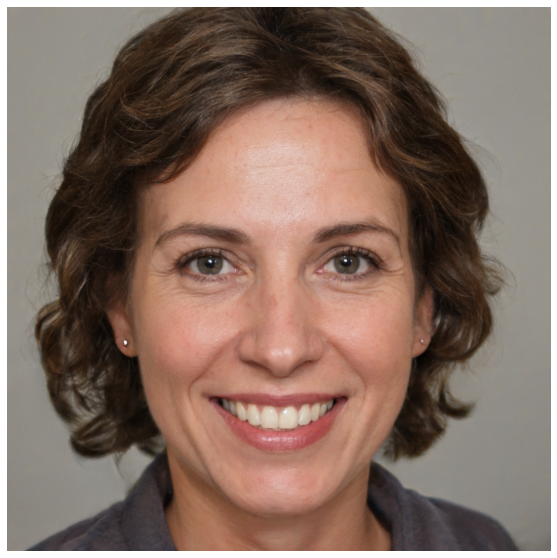

In [148]:
imgs = [] # array to hold all generated images
for seed in seeds:
  z = generate_latent_vector(seed, z_shape) # generate latent vector
  imgs.append(generate_image(z, label)) # generate image (face)

# set maximum number of images to plot in a row = 6
if len(imgs) > 6: ncols = 6
else: ncols = len(imgs)

# show images
im_show(imgs, ncols=ncols, img_size=10) # modify img_size to change plot size

**Select coefficient(s) to apply**

In [69]:
# Learned Coefficients
# Select any from those listed below

# SVC_gender_coefs, SVR_gender_coefs
# SVC_glasses_coefs, SVR_glasses_coefs
# SVC_hat_coefs, SVR_hat_coefs
# SVC_head_pose_coefs_0, SVC_head_pose_coefs_1_2, SVR_head_pose_coefs
# SVC_hair_length_male_coefs_1, SVC_hair_length_male_coefs_0_2, SVR_hair_length_male_coefs
# SVC_hair_length_female_coefs_1, SVC_hair_length_female_coefs_0_2, SVR_hair_length_female_coefs
# SVC_earring_coefs_1, SVC_earring_coefs_0_2, SVR_earring_coefs
# SVC_facial_hair_coefs_1, SVC_facial_hair_coefs_0_2, SVR_facial_hair_coefs
# SVC_smile_coefs_0_3, SVC_smile_coefs_1_2, SVR_smile_coefs

In [103]:
coefficients = [SVC_smile_coefs_0_3, SVC_smile_coefs_1_2, SVR_smile_coefs]

**Transform and Show Faces**

<u><b>| Seed 2000 | Coefficient 0 |</b></u>

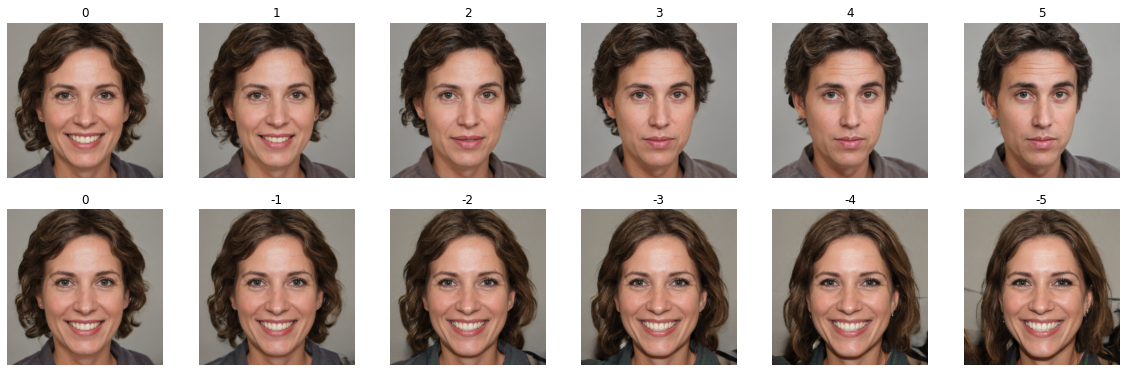

<u><b>| Seed 2000 | Coefficient 1 |</b></u>

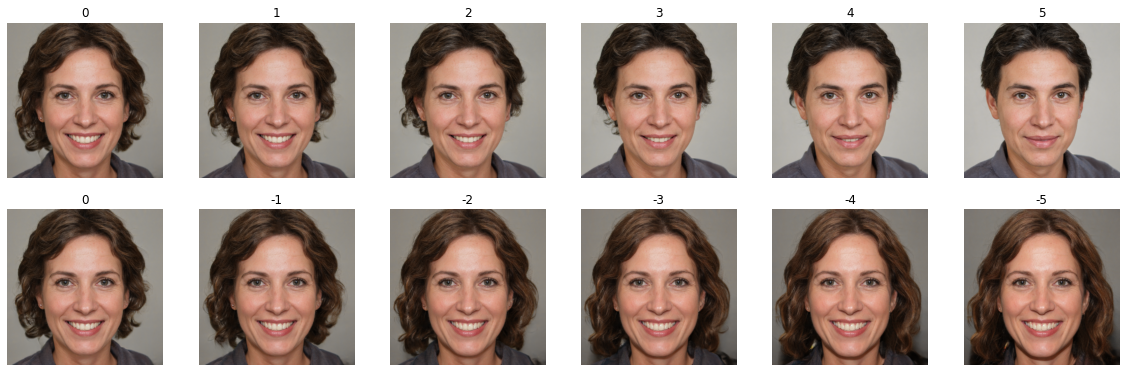

<u><b>| Seed 2000 | Coefficient 2 |</b></u>

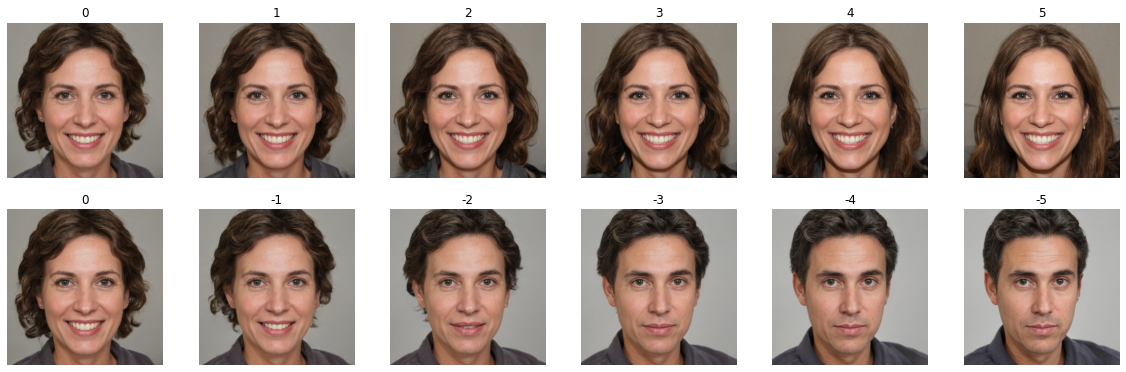

In [149]:
# if the plot size is too big/small, it can modified by adjusting the img_size value
apply_coefficient_to_img(coefficients=coefficients, 
                       seeds=seeds, 
                       intensity=5, 
                       scale=1,
                       img_size=20)

---
# **Extra. Transforming a Projection Face**

In [109]:
from PIL import Image

In [172]:
# load a previously projected face
ws = np.load('/content/LeonardoDicaprio.npz')['w']

In [173]:
coefficients = [SVC_smile_coefs_0_3, SVC_smile_coefs_1_2, SVR_smile_coefs]

<u><b>| Seed 2000 | Coefficient 0 |</b></u>

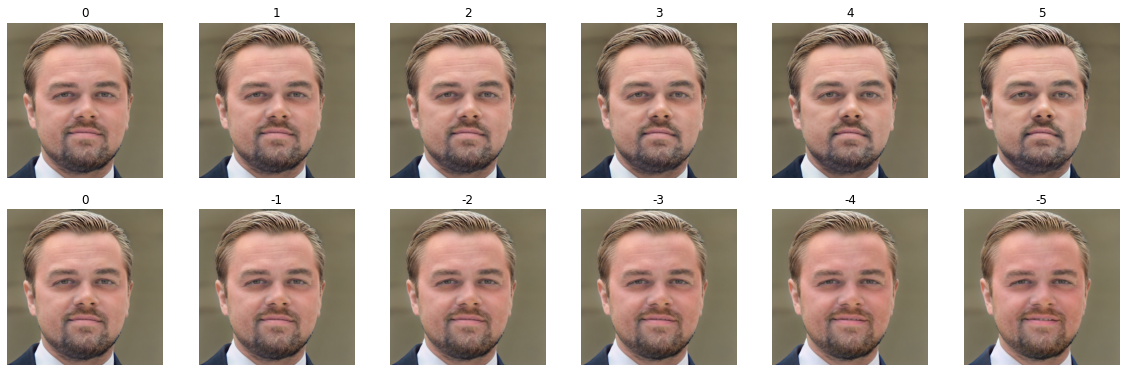

<u><b>| Seed 2000 | Coefficient 1 |</b></u>

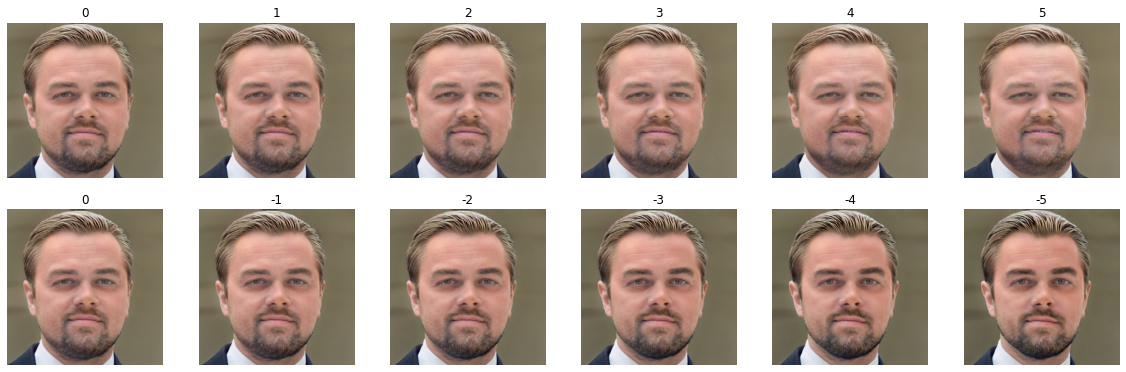

<u><b>| Seed 2000 | Coefficient 2 |</b></u>

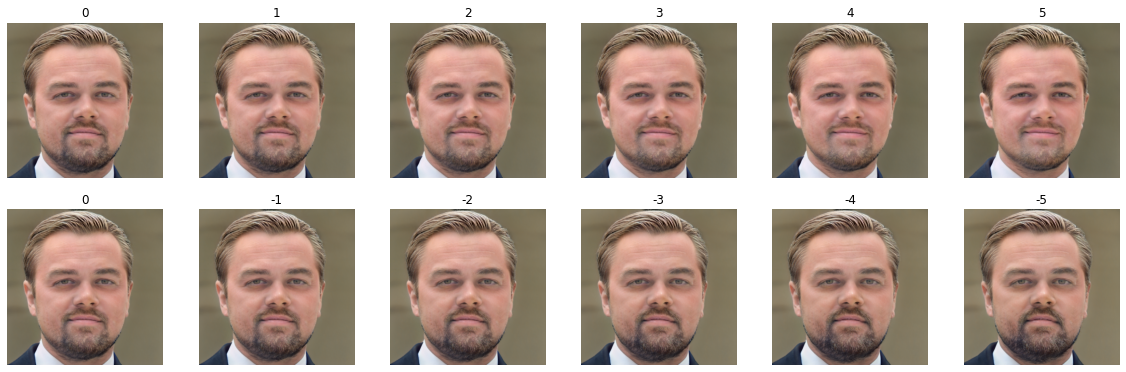

In [174]:
# seeds argument is ignored when transforming a projected face
apply_coefficient_to_img_projected(coefficients=coefficients,
                                  projected_ws=ws,
                                  intensity=5, 
                                  scale=1,
                                  img_size=20)